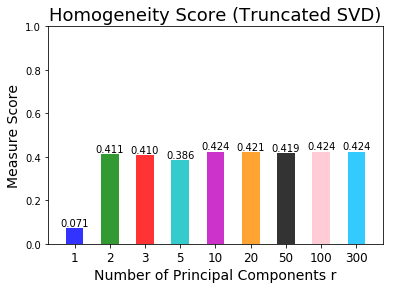

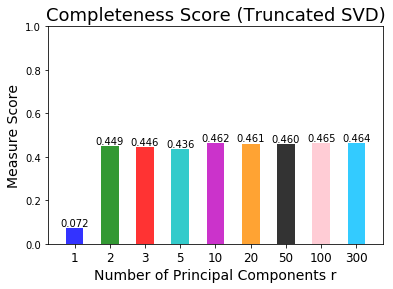

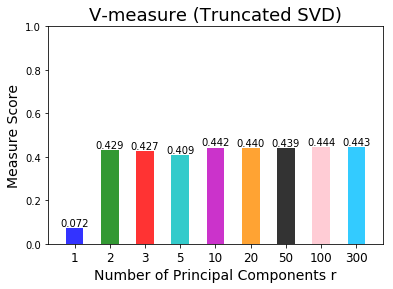

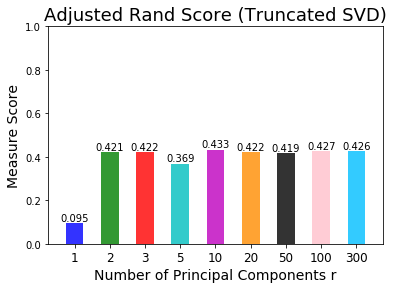

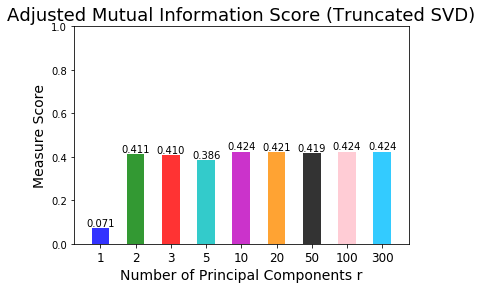

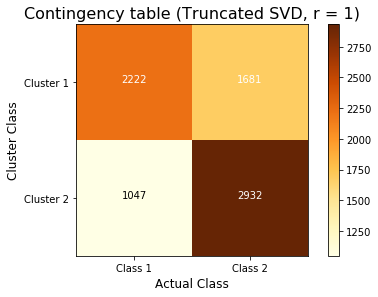

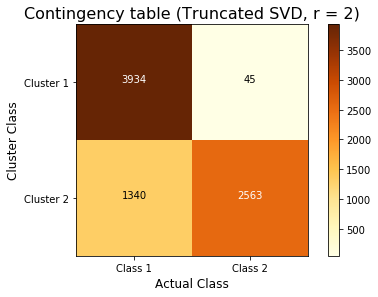

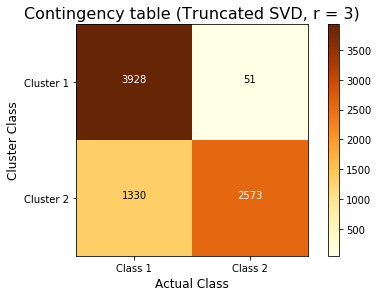

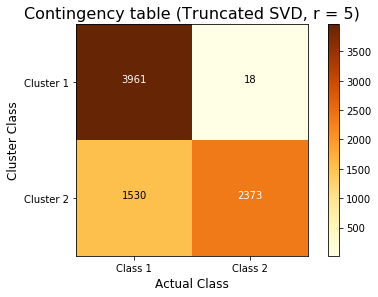

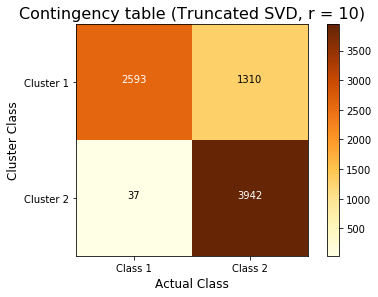

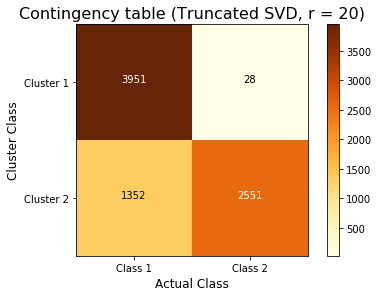

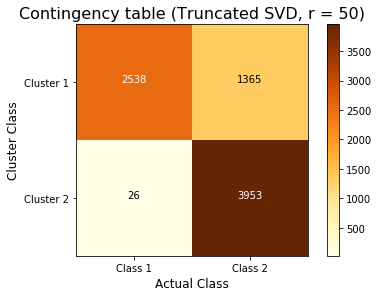

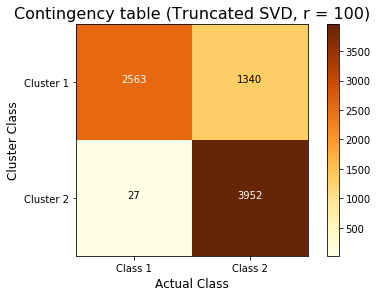

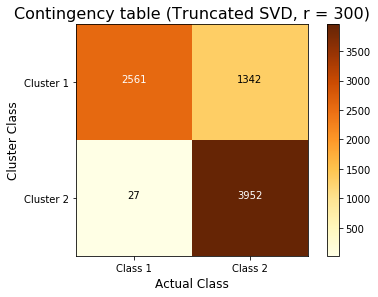

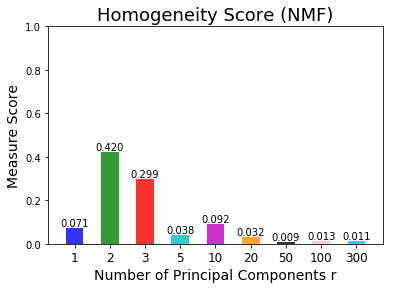

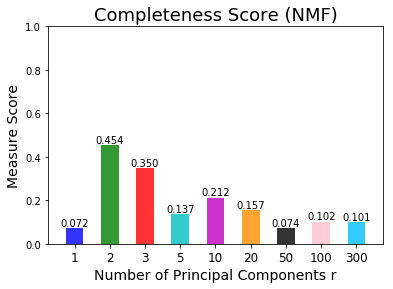

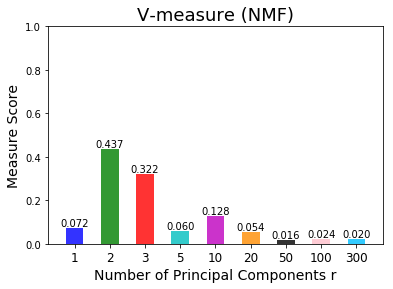

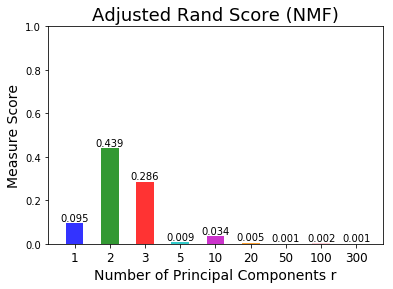

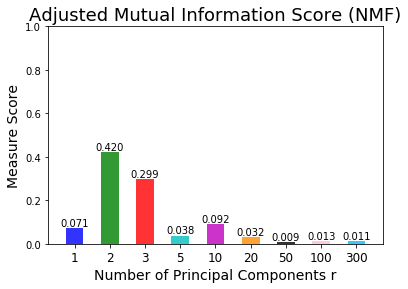

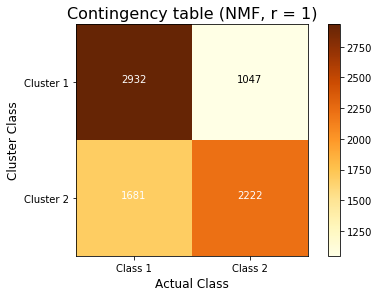

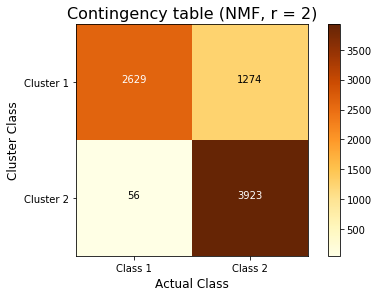

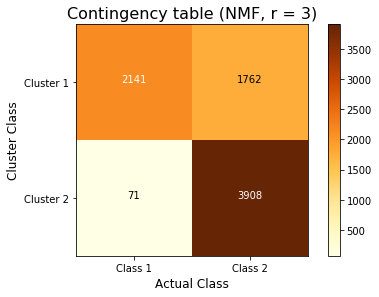

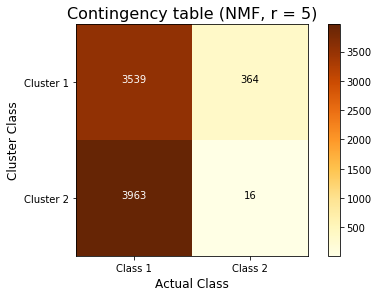

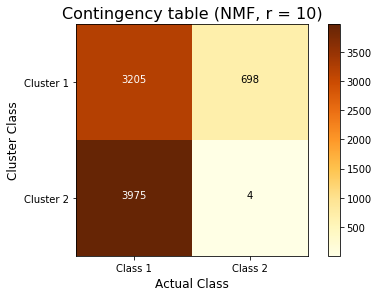

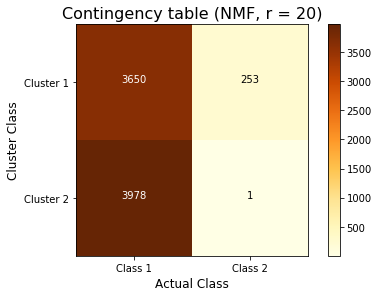

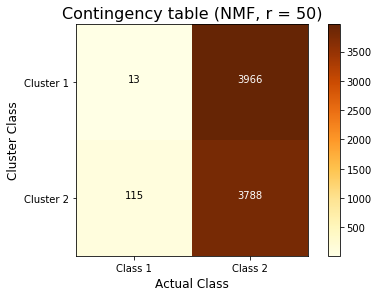

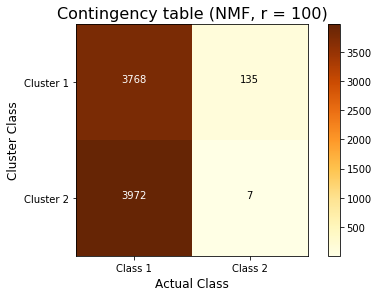

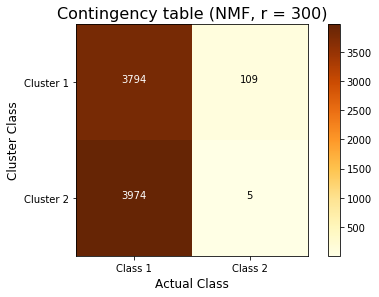

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# fetch original data
comp_tech_subclasses = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']             
rec_act_subclasses = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=comp_tech_subclasses+rec_act_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

# seperate all data into two classes
labels = [1]*len(dataset.data)
for i in range(len(dataset.data)):
    if dataset.target[i] > 3:
        labels[i] = 0

# trim data
def trim_data(data_list):
    for i in range(len(data_list)):
        temp = re.findall('[a-zA-Z]+', data_list[i])
        ans = []
        for j in range(len(temp)):
            if not temp[j].isdigit():
                ans.append(temp[j])           
        data_list[i] = " ".join(ans)
        
trim_data(dataset.data)

# generate TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=3, stop_words='english', use_idf=True)
X = vectorizer.fit_transform(dataset.data)

# reduce dimension
nums = [1, 2, 3, 5, 10, 20, 50, 100, 300]
svd = TruncatedSVD(n_components = 300, n_iter = 10,random_state = 42)
temp_res = svd.fit_transform(X)
lsi_res = []
for index in nums:
    lsi_res.append(temp_res[:, 0:index])

nmf_res = []
for terms in nums:
    nmf = NMF(n_components=terms, init='random', random_state=0)
    nmf_res.append(nmf.fit_transform(X))

# transform confusion matrix to diagonal as much as possible (only for 2 * 2 sized confusion)
def to_diagonal(confusion):
    maxColIndices = []
    copy = []
    for row in range(len(confusion)):
        curRow = confusion[row]
        index = 0
        value = curRow[0]
        ro = []
        for col in range(len(curRow)):
            ro.append(curRow[col])
            if curRow[col] > value:
                index = col
                value = curRow[col]
        maxColIndices.append(index)
        copy.append(ro)
    res = []
    for i in range(len(confusion)):
        res.insert(maxColIndices[i], copy[i])
    res = np.array(res)
    return res
    
# K-Means Clustering
def k_means(data, nums, labels):
    homogeneity = []
    completeness = []
    v_measure = []
    rand_score = []
    mutual_info_score = []
    plots = []
    plots.append(homogeneity)
    plots.append(completeness)
    plots.append(v_measure)
    plots.append(rand_score)
    plots.append(mutual_info_score)
    contin = []
    for index in range(len(nums)):
        km = KMeans(n_clusters=2)
        km.fit(data[index])
        confusion = metrics.confusion_matrix(labels, km.labels_)
        contingency = to_diagonal(confusion)
        contin.append(contingency)
        homogeneity.append(metrics.homogeneity_score(labels, km.labels_))
        completeness.append(metrics.completeness_score(labels, km.labels_))
        v_measure.append(metrics.v_measure_score(labels, km.labels_))
        rand_score.append(metrics.adjusted_rand_score(labels, km.labels_))
        mutual_info_score.append(metrics.adjusted_mutual_info_score(labels, km.labels_))
    return plots, contin

measures = ['Homogeneity Score', 'Completeness Score', 'V-measure', 'Adjusted Rand Score', 'Adjusted Mutual Information Score']
method = ['Truncated SVD', 'NMF']

# plot 5 measures
def plot_histogram(reduce_dimension_method, measure, ydata):
    x_labels = ['1', '2', '3', '5', '10', '20', '50', '100', '300']
    fig, ax = plt.subplots()
    color = ['b', 'g', 'r', 'c', 'm', 'darkorange', 'k', 'pink', 'deepskyblue']
    ax.set_xticks([i+0.25 for i in range(1,10)])
    ax.set_xticklabels(x_labels, fontsize = 12)
    
    rects = plt.bar([i for i in range(1,10)], ydata, 0.5, align='edge', alpha = 0.8, color = color)
    plt.xlabel('Number of Principal Components r', fontsize = 14)
    plt.ylabel('Measure Score', fontsize = 14)
    plt.title(measure+' ('+reduce_dimension_method+')', fontsize = 18)
    plt.axis([0.5,10,0,1])
    
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%.3f' % float(height), ha='center', va='bottom')
    
    plt.show()

# contingency table (confusion matrix)
actual_class_names = ['Class 1', 'Class 2']
cluster_class_names = ['Cluster 1', 'Cluster 2']
def plot_contingency_table(cm, title='Contingency table', cmap=plt.cm.YlOrBr):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(actual_class_names))
    plt.xticks(tick_marks, actual_class_names)
    plt.yticks(tick_marks, cluster_class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Cluster Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)    

# 1 SVD:
res_svd = k_means(lsi_res, nums, labels)
# plot 5 measures scores
for i in range(5):
    plot_histogram(method[0], measures[i], res_svd[0][i])
# Plot non-normalized contingency table
for i in range(9):
    plt.figure()
    title = 'Contingency table (Truncated SVD, r = ' + str(nums[i]) + ')'
    plot_contingency_table(res_svd[1][i], title=title)
    plt.show()

# 2 NMF
res_nmf = k_means(nmf_res, nums, labels)
# plot 5 measures scores
for i in range(5):
    plot_histogram(method[1], measures[i], res_nmf[0][i])
# Plot non-normalized contingency table
for i in range(9):
    plt.figure()
    title = 'Contingency table (NMF, r = ' + str(nums[i]) + ')'
    plot_contingency_table(res_nmf[1][i], title=title)
    plt.show()
